<a href="https://colab.research.google.com/github/jchen-1122/CLRS/blob/master/stockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# **Stock Prediction using Machine Learning**

This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation of using the past 60 day stock price. **Please enter your desired stock in the cell below.** By default, we are going to analyze the Apple stock (AAPL).


In [0]:
stock = 'AAPL'

**Choose a year that your model will start to trained on.** The longer the time frame, the more data the model will train on. However, the more the data, the longer the model will run for and could possibly result in overfitting. Choose wisely! By default, we will look at the stock prices from January 1, 2012.

In [0]:
year = 2012

In [181]:
def transform_year_to_dt(year):
  return str(year) + '-01-01'

# Get the stock quote
df = web.DataReader(stock, data_source='yahoo', start=transform_year_to_dt(year), end=date.today())

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2020-02-14,325.980011,322.850006,324.739990,324.950012,20028400.0,324.950012
2020-02-18,319.750000,314.609985,315.359985,319.000000,38132800.0,319.000000
2020-02-19,324.570007,320.000000,320.000000,323.619995,23496000.0,323.619995


Below is the current close price history graph of the stock with price as a function of time.

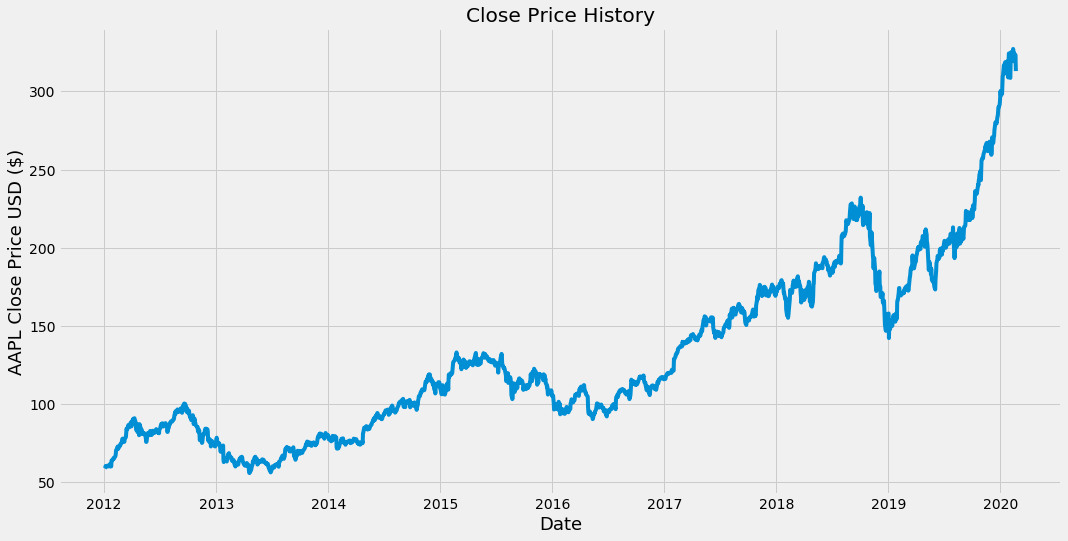

In [185]:
# Data visualizaton of closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel(stock+' Close Price USD ($)', fontsize=18)
plt.show()

**Choose the size of your training dataset as a percentage of the total dataset.** Typically, our training dataset size should be larger than our validation and test dataset size. By default, the training dataset length is set to 80% of the entire dataset.

In [0]:
training_data_size = 0.8

In [0]:
# create a dataframe with only the 'Close' column
data = df.filter(['Close'])

# convert dataframe into numpy array
dataset = data.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * training_data_size)

# scale/normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

Another important component of the training data size is each individual length. How many days are relevant to predicting the price of a stock? 1 month? 3 months? **Choose a time frame that you believe is enough to determine this information in days.** By default we set this to 60 days, or two months.

In [0]:
days = 60

In [0]:
# Create training dataset
# Create the scaled training_data_set
train_data = scaled_data[0: training_data_len, :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(days, len(train_data)):
  x_train.append(train_data[i-days: i, 0])
  y_train.append(train_data[i, 0])

# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data (LSTM expects 3D)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# **Our Model**
Our model uses two LSTM layers and two Dense layers. Of course, our model is just one of many possible models that can be used to fit our training data. In practice, LSTM is a valuable tool that is used in many financial modeling contexts. Another customizable feature within each layer is the number of neurons. Again, choosing too few neurons can cause accuracy issues and choosing too many can cause overfitting problems. This logic also applies to the number of layers in our model. The optimal amount of neurons also depends on the dataset size and training data size. **Choose the number of neurons in the LSTM layer.** By default, there are 50 neurons in each layer.

In [0]:
neurons = 50

In [0]:
# Build LSTM model
model = Sequential()
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(neurons, return_sequences=False))
half_neurons = math.ceil(neurons / 2)
model.add(Dense(half_neurons))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

After choosing the number of neurons at each layer and compiling the layers into a single model, we can decide how our model fits the data. Batch size refers to the number of training examples in each iteration. Epochs refers to the number of iterations there are. Increasing batch size will decrease the running time and increasing the number of epochs will dramatically increase the running time. Again, the issue of overfitting comes into play, so choose wisely. **Choose the batch_size and epoch numbers.** By default, both are set to 1.

In [0]:
batch_size = 1
epochs = 1

# **Train your Data on your Model!**
You may have to wait a few minutes. The model will be finished running when all epochs are finished iterating.

In [210]:
# Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/1
1578/1578 [==============================] - 120s 76ms/step - loss: 2.3164e-04


In [0]:
# create the testing dataset
# create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - days: , :]

# create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(days, len(test_data)):
  x_test.append(test_data[i-days:i, 0])

# convert the data to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

How well did our model do? Below is the root mean squared error. The closer the number is to zero, the better our model fitted. the dataset.

In [212]:
# get root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10.956429292636862

In fact, we can show how well our model did by the graph below. The blue region refers to our test data and the right region with two colors shows the actual stock price and the predicted price. How well did your model do?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


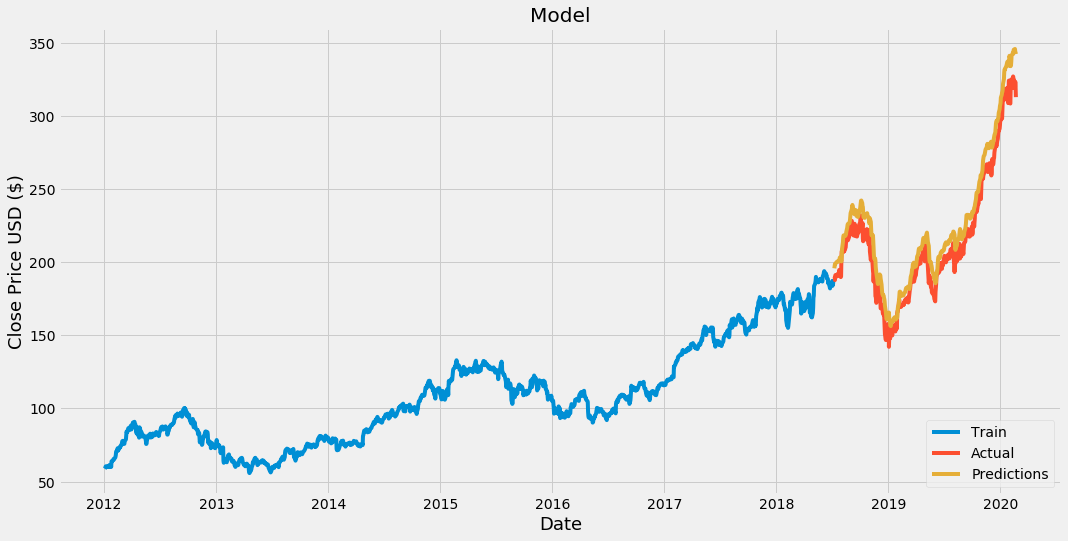

In [213]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()


In [0]:
# get the quote 
quote = web.DataReader(stock, data_source='yahoo', start=transform_year_to_dt(year), end=date.today())

# create a new dataframe
new_df = apple_quote.filter(['Close'])
# get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# create an empty list
X_test = []
# append past 60 days 
X_test.append(last_60_days_scaled)
# convert the X_test to a numpy array
X_test = np.array(X_test)
# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# get predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)

Below is a chart that is equivalent to the graph above. The numbers shown on the right column are the model's predicted values and the middle column is the actual closing price. Notice that the chart only contains our test data and not our training data as we only used our model to train with our training data and predict with our testing data.

In [228]:
valid = valid.rename(columns={"Close": "Actual Closing Price"})
valid

,Actual Closing Price,Predictions
Date,,
2018-07-09,190.580002,195.907425
2018-07-10,190.350006,197.475021
2018-07-11,187.880005,198.774734
2018-07-12,191.029999,198.793930
2018-07-13,191.330002,199.334991
...,...,...
2020-02-14,324.950012,345.467682
2020-02-18,319.000000,346.015381
2020-02-19,323.619995,344.013245


**Feel free to go back and change some of the customizable things like stock, year, batch_size, epochs, etc to fit your data on a different model.**